In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from PIL import Image
from torchvision.utils import save_image

# Choose variants here:

In [2]:
arch = 'MnistResNet18'
num_images = 8
trained_model = False
data_set = 'MNIST'
img_shape = (1, 28, 28)
num_classes = 10
num_channels  = 1

## System setup:

In [3]:
import inversefed
setup = inversefed.utils.system_startup()
defs = inversefed.training_strategy('conservative')

loss_fn, trainloader, validloader =  inversefed.construct_dataloaders(data_set, defs)

model, _ = inversefed.construct_model(arch, num_classes=num_classes, num_channels=num_channels)
model.to(**setup)
if trained_model:
    epochs = 120
    file = f'{arch}_{epochs}.pth'
    try:
        model.load_state_dict(torch.load(f'models/{file}'))
    except FileNotFoundError:
        inversefed.train(model, loss_fn, trainloader, validloader, defs, setup=setup)
        torch.save(model.state_dict(), f'models/{file}')
model.eval();

Currently evaluating -------------------------------:
Sunday, 20. December 2020 03:22PM
CPUs: 12, GPUs: 2 on dmsx-MS-7B94.
GPU : GeForce RTX 2080 Ti
Model initialized with random key 3987926501.


In [4]:
dm = torch.as_tensor(inversefed.consts.mnist_mean, **setup)[:, None, None]
ds = torch.as_tensor(inversefed.consts.mnist_std, **setup)[:, None, None]
def plot(tensor):
    tensor = tensor.clone().detach()
    tensor.mul_(ds).add_(dm).clamp_(0, 1)
    if tensor.shape[0] == 1:
        return plt.imshow(tensor[0].permute(1, 2, 0).cpu());
    else:
        fig, axes = plt.subplots(num_images // 8, 8, figsize=(20, 30))
        if num_images <= 8:
            for i, im in enumerate(tensor):
                axes[i].imshow(im.permute(1, 2, 0).cpu());
        else:
            for i, im in enumerate(tensor):
                x = i // 8
                y = i % 8
                axes[x, y].imshow(im.permute(1, 2, 0).cpu());


# Reconstruct

### Build the input (ground-truth) gradient

In [5]:
if num_images == 1:
    ground_truth_image = torch.as_tensor(np.array(Image.open("auto.jpg").resize((32, 32), Image.BICUBIC)) / 255, 
                                         **setup)
    ground_truth = ground_truth_image.permute(2, 0, 1).sub(dm).div(ds).unsqueeze(0).contiguous()
    labels = torch.as_tensor((1,), device=setup['device'])
else:
    ground_truth, labels = [], []
    idx = 25 # choosen randomly ... just whatever you want
    while len(labels) < num_images:
        img, label = validloader.dataset[idx]
        idx += 1
        labels.append(torch.as_tensor((label,), device=setup['device']))
        ground_truth.append(img.to(**setup))
    ground_truth = torch.stack(ground_truth)
    labels = torch.cat(labels)

In [6]:
local_lr = 1e-4
local_steps = 5
use_updates = True

In [7]:
model.zero_grad()
target_loss, _, _ = loss_fn(model(ground_truth), labels)
input_parameters = inversefed.reconstruction_algorithms.loss_steps(model, ground_truth, labels, 
                                                        lr=local_lr, local_steps=local_steps,
                                                                   use_updates=use_updates)
input_parameters = [p.detach() for p in input_parameters]

It: 0. Rec. loss: 0.2453.
It: 500. Rec. loss: 0.0643.
It: 1000. Rec. loss: 0.0671.
It: 1500. Rec. loss: 0.0664.
It: 2000. Rec. loss: 0.0579.
It: 2500. Rec. loss: 0.0615.
It: 3000. Rec. loss: 0.0652.
It: 3500. Rec. loss: 0.0620.
It: 4000. Rec. loss: 0.0674.
It: 4500. Rec. loss: 0.0650.
It: 5000. Rec. loss: 0.0678.
It: 5500. Rec. loss: 0.0636.
It: 6000. Rec. loss: 0.0709.
It: 6500. Rec. loss: 0.0676.
It: 7000. Rec. loss: 0.0649.
It: 7500. Rec. loss: 0.0677.
It: 8000. Rec. loss: 0.0718.
It: 8500. Rec. loss: 0.0656.
It: 9000. Rec. loss: 0.0652.
It: 9500. Rec. loss: 0.0476.
It: 10000. Rec. loss: 0.0481.
It: 10500. Rec. loss: 0.0440.
It: 11000. Rec. loss: 0.0449.
It: 11500. Rec. loss: 0.0473.
It: 12000. Rec. loss: 0.0477.
It: 12500. Rec. loss: 0.0480.
It: 13000. Rec. loss: 0.0471.
It: 13500. Rec. loss: 0.0532.
It: 14000. Rec. loss: 0.0527.
It: 14500. Rec. loss: 0.0512.
It: 15000. Rec. loss: 0.0483.
It: 15500. Rec. loss: 0.0439.
It: 16000. Rec. loss: 0.0393.
It: 16500. Rec. loss: 0.0404.
It: 

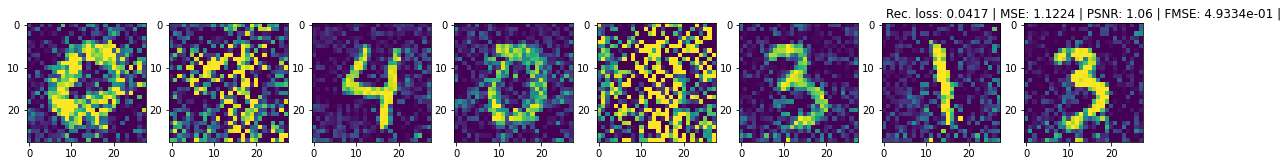

In [8]:
config = dict(signed=True,
              boxed=True,
              cost_fn='sim',
              indices='def',
              weights='equal',
              lr=1,
              optim='adam',
              restarts=2,
              max_iterations=24000,
              total_variation=1e-6,
              init='randn',
              filter='none',
              lr_decay=True,
              scoring_choice='loss')

rec_machine = inversefed.FedAvgReconstructor(model, (dm, ds), local_steps, local_lr, config,
                                             use_updates=use_updates, num_images=num_images)
output, stats = rec_machine.reconstruct(input_parameters, labels, img_shape=img_shape)

test_mse = (output.detach() - ground_truth).pow(2).mean()
feat_mse = (model(output.detach())- model(ground_truth)).pow(2).mean()  
test_psnr = inversefed.metrics.psnr(output, ground_truth)

plot(output)
plt.title(f"Rec. loss: {stats['opt']:2.4f} | MSE: {test_mse:2.4f} "
          f"| PSNR: {test_psnr:4.2f} | FMSE: {feat_mse:2.4e} |");

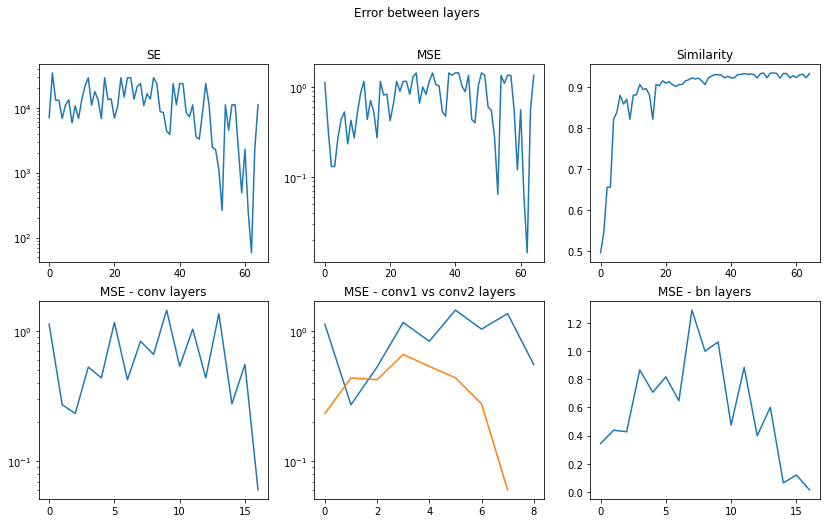

In [9]:
data = inversefed.metrics.activation_errors(model, output, ground_truth)

fig, axes = plt.subplots(2, 3, sharey=False, figsize=(14,8))
axes[0, 0].semilogy(list(data['se'].values())[:-3])
axes[0, 0].set_title('SE')
axes[0, 1].semilogy(list(data['mse'].values())[:-3])
axes[0, 1].set_title('MSE')
axes[0, 2].plot(list(data['sim'].values())[:-3])
axes[0, 2].set_title('Similarity')

convs = [val for key, val in data['mse'].items() if 'conv' in key]
axes[1, 0].semilogy(convs)
axes[1, 0].set_title('MSE - conv layers')
convs = [val for key, val in data['mse'].items() if 'conv1' in key]
axes[1, 1].semilogy(convs)
convs = [val for key, val in data['mse'].items() if 'conv2' in key]
axes[1, 1].semilogy(convs)
axes[1, 1].set_title('MSE - conv1 vs conv2 layers')
bns = [val for key, val in data['mse'].items() if 'bn' in key]
axes[1, 2].plot(bns)
axes[1, 2].set_title('MSE - bn layers')
fig.suptitle('Error between layers');

In [10]:
psnrs = []
for i in range(num_images):
    p = inversefed.metrics.psnr(output[i: i+1], ground_truth[i:i+1])
    print(p)
    psnrs.append(p)

0.7397934198379517
-3.11889910697937
7.677203178405762
2.679612874984741
-5.2661027908325195
0.8282051086425781
3.8135251998901367
1.1287716627120972


In [11]:
print(output.shape)

torch.Size([8, 1, 28, 28])


In [12]:
print(ground_truth.shape)

torch.Size([8, 1, 28, 28])


In [13]:
gt = ground_truth.clone().detach().cpu()
gt_numpy = gt.numpy()
np.save(f'mul_img{num_images}{arch}{data_set}gtbatch', gt_numpy)

ot = output.clone().detach().cpu()
ot_numpy = ot.numpy()
np.save(f'mul_img{num_images}{arch}{data_set}otbatch', ot_numpy)

['0 - zero', '7 - seven', '4 - four', '0 - zero', '1 - one', '3 - three', '1 - one', '3 - three']


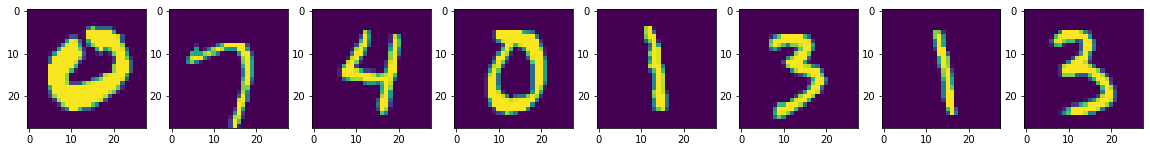

In [14]:
plot(ground_truth);
print([validloader.dataset.classes[l] for l in labels]);

In [15]:
def plot1_psrns(tensor, num_images=num_images, psrns=psnrs):
    tensor = tensor.clone().detach()
    tensor.mul_(ds).add_(dm).clamp_(0, 1)
    if tensor.shape[0] == 1:
        return plt.imshow(tensor[0].permute(1, 2, 0).cpu());
    else:
        fig, axes = plt.subplots(num_images // 8, 8, figsize=(20, 30))
        if num_images <= 8:
            for i, im in enumerate(tensor):
                axes[i].imshow(im.permute(1, 2, 0).cpu());
        else:
            count = 0
            for i, im in enumerate(tensor):
                x = i // 8
                y = i % 8
                axes[x, y].imshow(im.permute(1, 2, 0).cpu());
                axes[x, y].set_title(psnrs[count])
                count = count + 1
